In [ ]:
# Step 0: imports & settings

import os
import json
import re
import numpy as np
import pandas as pd
from ast import literal_eval
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')



In [2]:
os.environ["KAGGLE_CONFIG_DIR"] = "."

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
api.dataset_download_files(
    'shubhamsingh42/flight-delay-dataset-2018-2024',
    path='./newData',                      
    unzip=True                       
)

print("Dataset downloaded successfully!")


Dataset URL: https://www.kaggle.com/datasets/shubhamsingh42/flight-delay-dataset-2018-2024
Dataset downloaded successfully!


In [4]:
data_file = "newData/flight_data_2018_2024.csv"
df = pd.read_csv(data_file, low_memory=False)

# Quick inspect
print("Rows,Cols:", df.shape)
display(df.head())
display(df.info())

# Basic missing values overview
missing = df.isnull().mean().sort_values(ascending=False)
display(missing[missing > 0].head(30))

# Take a reproducible sample for development (change sample_size if you want)
sample_size = 300000   # tweak according to RAM
if len(df) > sample_size:
    df = df.sample(sample_size, random_state=42).reset_index(drop=True)
    print("Sampled to", df.shape)
else:
    print("Using full dataset:", df.shape)


Rows,Cols: (582425, 120)


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
0,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582425 entries, 0 to 582424
Columns: 120 entries, Year to Unnamed: 119
dtypes: float64(70), int64(23), object(27)
memory usage: 533.2+ MB


None

Div5AirportID       1.000000
Div5Airport         1.000000
Div4TailNum         1.000000
Div4WheelsOff       1.000000
Div4LongestGTime    1.000000
Div4TotalGTime      1.000000
Div4WheelsOn        1.000000
Div4AirportID       1.000000
Unnamed: 119        1.000000
Div4Airport         1.000000
Div5TailNum         1.000000
Div5WheelsOff       1.000000
Div5LongestGTime    1.000000
Div5TotalGTime      1.000000
Div5WheelsOn        1.000000
Div5AirportSeqID    1.000000
Div4AirportSeqID    1.000000
Div3AirportID       0.999998
Div3LongestGTime    0.999998
Div3TotalGTime      0.999998
Div3AirportSeqID    0.999998
Div3Airport         0.999998
Div3TailNum         0.999998
Div3WheelsOn        0.999998
Div3WheelsOff       0.999998
Div2TailNum         0.999962
Div2WheelsOff       0.999962
Div2LongestGTime    0.999930
Div2Airport         0.999930
Div2TotalGTime      0.999930
dtype: float64

Sampled to (300000, 120)


In [5]:
# Step 2: basic cleanup & handle cancelled/diverted
# Convert FlightDate (yyyymmdd) to datetime if present
if 'FlightDate' in df.columns:
    df['FlightDate'] = pd.to_datetime(df['FlightDate'], format='%Y%m%d', errors='coerce')

# Keep only non-cancelled and non-diverted flights for ArrDel15 modeling
if 'Cancelled' in df.columns:
    df = df[df['Cancelled'] != 1].copy()
if 'Diverted' in df.columns:
    df = df[df['Diverted'] != 1].copy()
print("After removing Cancelled/Diverted:", df.shape)

# Ensure target present and numeric
if 'ArrDel15' in df.columns:
    df['ArrDel15'] = pd.to_numeric(df['ArrDel15'], errors='coerce').fillna(0).astype(int)
else:
    # create from ArrDelay or ArrDelayMinutes if needed
    if 'ArrDelay' in df.columns:
        df['ArrDel15'] = (pd.to_numeric(df['ArrDelay'], errors='coerce') > 15).astype(int).fillna(0)
print("ArrDel15 value counts:\n", df['ArrDel15'].value_counts(normalize=False))
print(df['ArrDel15'].value_counts(normalize=True))


After removing Cancelled/Diverted: (287785, 120)
ArrDel15 value counts:
 ArrDel15
0    218429
1     69356
Name: count, dtype: int64
ArrDel15
0    0.759001
1    0.240999
Name: proportion, dtype: float64


In [6]:
# # Step 3: helper to convert HHMM -> hour and minutes-since-midnight
# def hhmm_to_hour(x):
#     try:
#         x = int(x)
#         s = str(x).zfill(4)
#         hour = int(s[:2])
#         minute = int(s[2:])
#         return hour + minute/60.0
#     except:
#         return np.nan

# def hhmm_to_minutes(x):
#     try:
#         x = int(x)
#         s = str(x).zfill(4)
#         return int(s[:2])*60 + int(s[2:])
#     except:
#         return np.nan

# time_cols = ['CRSDepTime','DepTime','WheelsOff','WheelsOn','CRSArrTime','ArrTime',
#              'FirstDepTime','Div1WheelsOn','Div2WheelsOn']  # include candidates if present
# for c in time_cols:
#     if c in df.columns:
#         df[c + '_hour'] = df[c].apply(hhmm_to_hour)
#         df[c + '_min'] = df[c].apply(hhmm_to_minutes)

# # Create basic date parts
# if 'FlightDate' in df.columns:
#     df['year'] = df['FlightDate'].dt.year
#     df['month'] = df['FlightDate'].dt.month
#     df['dayofmonth'] = df['FlightDate'].dt.day
#     df['dayofweek'] = df['FlightDate'].dt.dayofweek  # monday=0


In [7]:
# Step 4: choose numeric candidate features and impute
numeric_candidates = [
 'DepDelay', 'DepDelayMinutes', 'DepartureDelayGroups', 'TaxiOut','TaxiIn',
 'ArrDelay','ArrDelayMinutes','ArrivalDelayGroups','CRSElapsedTime','ActualElapsedTime',
 'AirTime','Flights','Distance','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'
]
# include derived time features if created
for c in df.columns:
    if c.endswith('_hour') or c.endswith('_min'):
        numeric_candidates.append(c)

# keep only those present in df
numeric_candidates = [c for c in numeric_candidates if c in df.columns]
print("Numeric candidates found:", len(numeric_candidates))

# Convert to numeric and fill median
for c in numeric_candidates:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())


Numeric candidates found: 18


In [8]:
# Step 5: categorical handling (frequency encoding utility)
def freq_encode(series):
    vc = series.value_counts(normalize=True)
    return series.map(vc).fillna(0.0)

cat_cols = ['Marketing_Airline_Network','Operating_Airline','Origin','OriginCityName','OriginState',
            'Dest','DestCityName','DestState','Tail_Number','Flight_Number_Marketing_Airline']
cat_present = [c for c in cat_cols if c in df.columns]
print("Categorical columns to freq-encode:", cat_present)

for c in cat_present:
    df[c + '_freq'] = freq_encode(df[c])


Categorical columns to freq-encode: ['Marketing_Airline_Network', 'Origin', 'OriginCityName', 'OriginState', 'Dest', 'DestCityName', 'DestState', 'Tail_Number', 'Flight_Number_Marketing_Airline']


In [9]:
# Step 6: assemble feature list (start with a compact set)
features = []

# strong predictors
for f in ['DepDelay','DepDelayMinutes','TaxiOut','AirTime','Distance','CRSElapsedTime','ActualElapsedTime']:
    if f in df.columns:
        features.append(f)

# time/date features
for f in ['month','dayofweek','CRSDepTime_hour','DepTime_hour','CRSArrTime_hour','ArrTime_hour','FirstDepTime_hour']:
    if f in df.columns:
        features.append(f)

# add freq-encoded cats
for c in cat_present:
    features.append(c + '_freq')

# de-dupe and ensure present
features = [f for i,f in enumerate(features) if f in df.columns and f not in features[:i]]
print("Final feature list ({}):".format(len(features)), features[:30])


Final feature list (16): ['DepDelay', 'DepDelayMinutes', 'TaxiOut', 'AirTime', 'Distance', 'CRSElapsedTime', 'ActualElapsedTime', 'Marketing_Airline_Network_freq', 'Origin_freq', 'OriginCityName_freq', 'OriginState_freq', 'Dest_freq', 'DestCityName_freq', 'DestState_freq', 'Tail_Number_freq', 'Flight_Number_Marketing_Airline_freq']


In [14]:
features

['DepDelay',
 'DepDelayMinutes',
 'TaxiOut',
 'AirTime',
 'Distance',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Marketing_Airline_Network_freq',
 'Origin_freq',
 'OriginCityName_freq',
 'OriginState_freq',
 'Dest_freq',
 'DestCityName_freq',
 'DestState_freq',
 'Tail_Number_freq',
 'Flight_Number_Marketing_Airline_freq']

Top correlations with ArrDel15:
 ArrDel15                                1.000000
DepDelay                                0.475759
DepDelayMinutes                         0.459699
TaxiOut                                 0.297906
ActualElapsedTime                       0.094268
AirTime                                 0.034599
OriginCityName_freq                     0.027173
Origin_freq                             0.025323
DestState_freq                          0.014643
Distance                                0.009332
CRSElapsedTime                          0.008129
Flight_Number_Marketing_Airline_freq    0.003066
OriginState_freq                       -0.004541
Dest_freq                              -0.006708
DestCityName_freq                      -0.006719
Marketing_Airline_Network_freq         -0.007778
Tail_Number_freq                       -0.010335
Name: ArrDel15, dtype: float64
Top features for heatmap: ['ArrDel15', 'DepDelay', 'DepDelayMinutes', 'TaxiOut', 'ActualElapsedTime', '

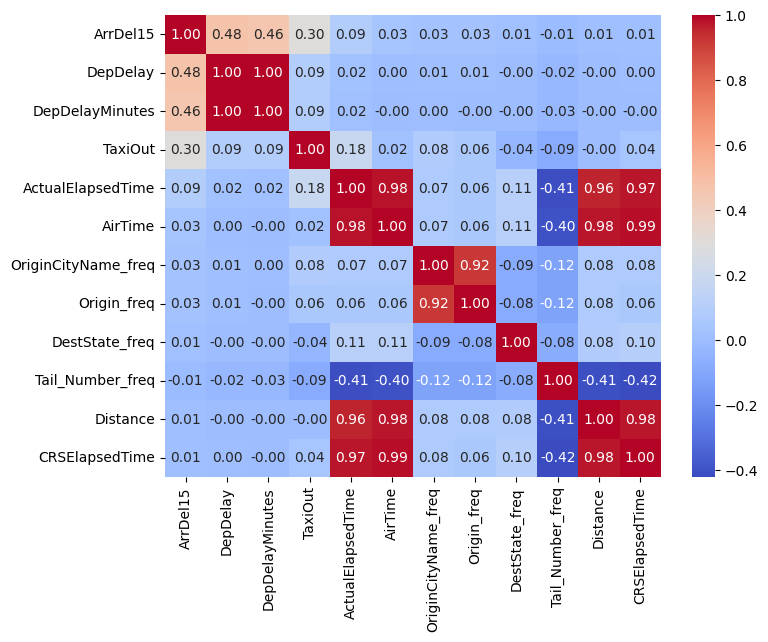

In [10]:
# Step 7: correlation with ArrDel15 to validate features
numeric_for_corr = [f for f in features if df[f].dtype.kind in 'fi']
numeric_for_corr.append('ArrDel15')
corr = df[numeric_for_corr].corr()
target_corr = corr['ArrDel15'].sort_values(ascending=False)
print("Top correlations with ArrDel15:\n", target_corr.head(30))

# Heatmap of top correlated features (by absolute corr)
top_feats = target_corr.abs().sort_values(ascending=False).head(12).index.tolist()
print("Top features for heatmap:", top_feats)
plt.figure(figsize=(8,6))
sns.heatmap(df[top_feats].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


In [30]:
df.query("WeatherDelay > 0")

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Unnamed: 119,Marketing_Airline_Network_freq,Origin_freq,OriginCityName_freq,OriginState_freq,Dest_freq,DestCityName_freq,DestState_freq,Tail_Number_freq,Flight_Number_Marketing_Airline_freq
9,2024,1,1,9,2,NaT,DL,DL_CODESHARE,19790,DL,...,NaN,0.203642,0.021610,0.037983,0.050089,0.005539,0.005539,0.013302,0.000233,0.000101
14,2024,1,1,9,2,NaT,G4,G4,20368,G4,...,NaN,0.015136,0.001077,0.001077,0.097955,0.002179,0.002179,0.019494,0.000163,0.000268
24,2024,1,1,13,6,NaT,AA,AA_CODESHARE,19805,AA,...,NaN,0.253905,0.000980,0.000980,0.002460,0.037875,0.047424,0.049457,0.000215,0.000268
34,2024,1,1,14,7,NaT,WN,WN,19393,WN,...,NaN,0.200094,0.012805,0.012805,0.019501,0.005886,0.005886,0.108817,0.000208,0.000275
112,2024,1,1,22,1,NaT,AA,AA_CODESHARE,19805,AA,...,NaN,0.253905,0.038004,0.047671,0.049957,0.002179,0.002179,0.019494,0.000247,0.000069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299563,2024,1,1,16,2,NaT,AA,AA,19805,AA,...,NaN,0.253905,0.033650,0.033650,0.047073,0.002714,0.002714,0.050340,0.000188,0.000285
299606,2024,1,1,17,3,NaT,DL,DL_CODESHARE,19790,DL,...,NaN,0.203642,0.016432,0.016432,0.017346,0.000546,0.000546,0.004927,0.000313,0.000125
299750,2024,1,1,6,6,NaT,NK,NK,20416,NK,...,NaN,0.035714,0.018917,0.018917,0.019747,0.024901,0.024901,0.098511,0.000236,0.000247
299851,2024,1,1,17,3,NaT,AA,AA_CODESHARE,19805,AA,...,NaN,0.253905,0.001001,0.001001,0.003440,0.020095,0.029526,0.037459,0.000240,0.000202


In [16]:
# Step 8: prepare X/y, split, scale
X = df[features].copy()
y = df['ArrDel15'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Train/test shapes:", X_train.shape, X_test.shape)


Train/test shapes: (230228, 16) (57557, 16)


In [18]:
# X_train["month"]

In [21]:
# ?

In [22]:
# Step 9: baseline model - LogisticRegression
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:,1]
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     43686
           1       0.97      1.00      0.98     13871

    accuracy                           0.99     57557
   macro avg       0.98      0.99      0.99     57557
weighted avg       0.99      0.99      0.99     57557

ROC-AUC: 0.9999752957458156
Confusion matrix:
 [[43201   485]
 [    0 13871]]


In [24]:
# Step 10: stronger model - XGBoost (tabular)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {'objective':'binary:logistic','eval_metric':'auc','eta':0.1,'max_depth':6,'seed':42}
bst = xgb.train(params, dtrain, num_boost_round=200)
y_prob_xgb = bst.predict(dtest)
y_pred_xgb = (y_prob_xgb > 0.5).astype(int)
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost ROC AUC: 0.9992565092153486
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43686
           1       0.98      0.96      0.97     13871

    accuracy                           0.99     57557
   macro avg       0.99      0.98      0.98     57557
weighted avg       0.99      0.99      0.99     57557



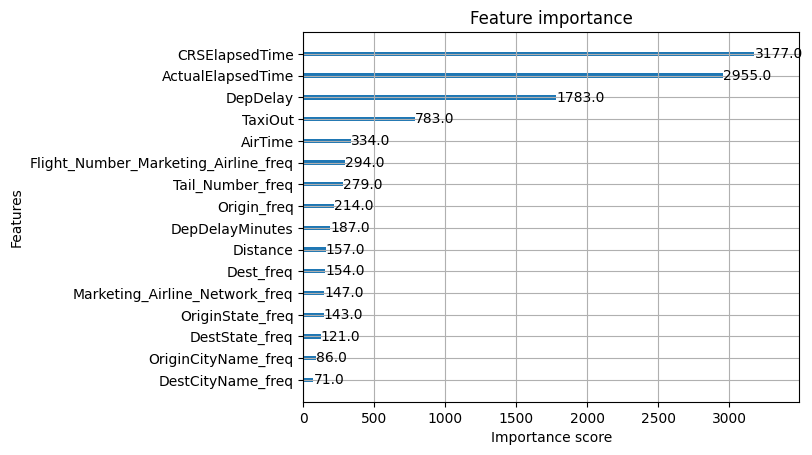

In [25]:
# Step 11: feature importance from XGBoost
xgb.plot_importance(bst, max_num_features=20)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

# Fit model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("ROC AUC:", auc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# ROC Curve
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Logistic Regression")
plt.show()


AttributeError: 'NaTType' object has no attribute 'normalize'

No flight_date column
Candidate features available: []


Correlation with arrdel15:
arrdel15                1.000000
ArrDel15                0.980111
ArrivalDelayGroups      0.762009
DepDel15                0.730512
DepartureDelayGroups    0.673387
ArrDelay                0.549694
ArrDelayMinutes         0.503236
DepDelay                0.476569
DepDelayMinutes         0.460960
TaxiOut                 0.293603
Div2WheelsOn            0.180629
WheelsOff               0.158902
DepTime                 0.155464
TaxiIn                  0.135449
ActualElapsedTime       0.092366
CRSDepTime              0.091217
CRSArrTime              0.084686
Div2TotalGTime          0.083984
WheelsOn                0.081554
ArrTime                 0.072415
Name: arrdel15, dtype: float64
Top features used in heatmap: ['arrdel15', 'ArrDel15', 'ArrivalDelayGroups', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'DepDelay', 'DepDelayMinutes', 'TaxiOut', 'Flight_Num_Originally_Scheduled_Code_Share_Airline']


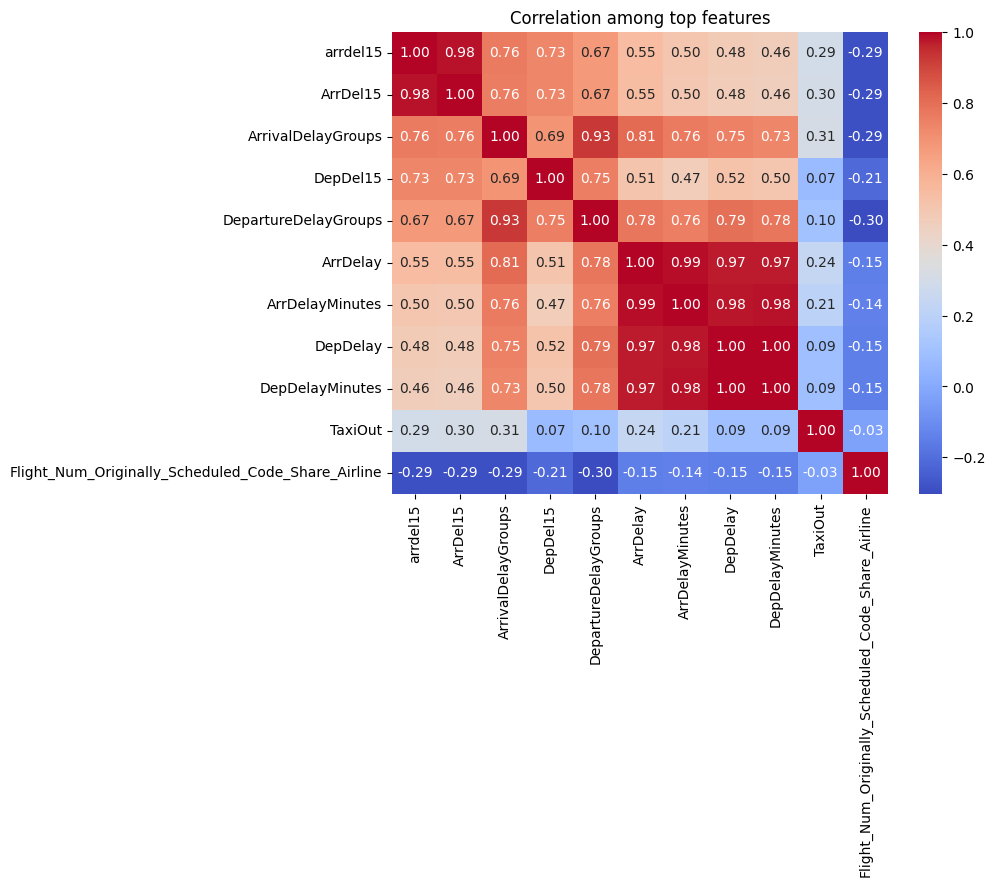